In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any

from agents_nodes.clear_valid_input_validator.input_validator import validate_medical_input_agent
from vision_models.input_image_classification.image_classifier import classify_image


c:\ProgramData\anaconda3\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
class AgentState(TypedDict):
    input_text: str
    attatchments: Dict[str, Any] # dict, each with {user naming for that attachment, the attachment path}

In [3]:
def first_input_validation_node(state: AgentState):
    input_text = state["input_text"]
    attachments = list(state["attatchments"].keys())

    first_input_validation_result = validate_medical_input_agent(input_text, attachments)
    state["input_validation_result"] = first_input_validation_result
    state["coming_from_validation"] = "first_input_text"

    return state

In [4]:
def input_not_valid_fallback_node(state: AgentState):
    validation_results = state["input_validation_result"]

    if state["coming_from_validation"] == "first_input_text":

        if validation_results == "TEXT_VALID_ATTACHMENT_NOT_VALID":
            pass
        elif validation_results == "TEXT_NOT_VALID_ATTACHMENT_VALID":
            pass
        elif validation_results == "TEXT_NOT_VALID_ATTACHMENT_NOT_VALID":
            pass
    
    elif state["coming_from_validation"] == "second_input_text":
        pass # TODO will be implemented later (Not a valid extracted text)

    elif state["coming_from_validation"] == "input_image":
        pass # TODO will be implemented later (Not a valid image)
    
    return state

In [5]:
def input_image_classification_node(state: AgentState):
    input_images_titles_and_paths = state["input_images_titles_and_paths"] # should be a dictionarie with 'title' key and 'path' value for each item

    results = [] # a list of lists, each list have [title, path, classification]
    for title, path in input_images_titles_and_paths.items():
        classification = classify_image(title, path)

        results.append([title, path, classification])
    
    state["input_images_classification_results"] = results

    return state

In [6]:
def first_input_validation_route(state: AgentState):
    if state["input_validation_result"] == "TEXT_VALID_ATTACHMENT_VALID":
        pass # TODO will be implemented later
    else:
        return "input_not_valid_fallback_node"

In [7]:
def input_image_classification_route(state: AgentState):
    full_images_results = state["input_images_classification_results"]
    medical_images = []
    text_images = []

    for image_result in full_images_results:

        # image_result[0] = title
        # image_result[1] = path
        # image_result[2] = classification

        if image_result[2] == "text":
            text_images.append(image_result) # for The extract text from image node

        elif image_result[2] == "not_valid_image":
            state["coming_from_validation"] = "input_image"
            return "input_not_valid_fallback_node"
        
        else: # medical images
            medical_images.append(image_result)
        
    
    # TODO should be able to call 2 nodes (the medical vision models node and the extract text from image node)


In [8]:
def input_splitter_route(state: AgentState):
    if state["input_validation_result"] != "TEXT_VALID_ATTACHMENT_VALID":
        return "input_not_valid_fallback_node"

    text_provided = True if state['input_text'] else False

    attachments_files = {}
    attachments_images = {}

    for key, value in state['attatchments'].items():
        if value.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            attachments_images[key] = value
        else:
            attachments_files[key] = value


    if text_provided and attachments_files and attachments_images:
        return ["extract_text_from_files_node", "input_image_classification_node"] # TODO will fix the names later

    if text_provided and attachments_files and not attachments_images:
        return "extract_text_from_files_node" # TODO will fix the names later
    
    if text_provided and not attachments_files and attachments_images:
        return ["numerical_models_agent_node", "input_image_classification_node"] # TODO will fix the names later

    if text_provided and not attachments_files and not attachments_images:
        return "numerical_models_agent_node" # TODO will fix the names later

    if not text_provided and attachments_files and attachments_images:
        return ["extract_text_from_files_node", "input_image_classification_node"] # TODO will fix the names later
    
    if not text_provided and attachments_files and not attachments_images:
        return "extract_text_from_files_node" # TODO will fix the names later
    
    if not text_provided and not attachments_files and attachments_images:
        return "input_image_classification_node"
    



In [9]:
workflow = StateGraph(AgentState)
workflow.add_node("first_input_validation_node", first_input_validation_node)
workflow.add_node("input_not_valid_fallback_node", input_not_valid_fallback_node)
workflow.add_node("input_image_classification_node", input_image_classification_node)

workflow.add_conditional_edges("first_input_validation_node", input_splitter_route)
workflow.add_conditional_edges("input_image_classification_node", input_image_classification_route)


In [13]:
workflow.set_entry_point("first_input_validation_node")
app = workflow.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


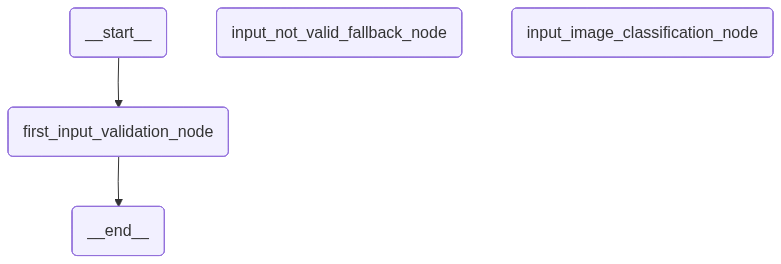

In [14]:
app